<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Using pyanodi
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
</p>
<p style="color:rgb(90,90,90);">
Copyright (c) 2020 Guillaume Rongier
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook shows how to use the functionalities of pyanodi for method comparison using Gaussian processes with different kernels as an example.

Pyanodi implements the ANODI method, which is based on analyzing pattern reproduction and variability between a training image and realizations from different stochastic simulation methods. For more details, see [Comparing Training-Image Based Algorithms Using an Analysis of Distance](https://doi.org/10.1007/s11004-013-9482-1) by Xiaojin Tan, Pejman Tahmasebi, and Jef Caers. 

# Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.manifold import MDS

from pyanodi import ANODI

# Data

Here we use [Gaussian processes from scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html) to generate a training image and some realizations to compare with the training image.

## Training image

In multiple-point simulation, the training image is an example of the features to simulate. It can be any image, and here we use Gaussian processes out of convenience.

In [2]:
extent_ti = np.array(((0, 750), (0, 750)))
shape_ti = (75, 75)

In [3]:
grid_ti = np.meshgrid(np.linspace(extent_ti[0, 0], extent_ti[0, 1], shape_ti[0]),
                      np.linspace(extent_ti[1, 0], extent_ti[1, 1], shape_ti[1]))
grid_ti = np.stack(grid_ti).T

In [4]:
kernel_ti = 1.*Matern(length_scale=(100., 100.), nu=1/2)
gp_ti = GaussianProcessRegressor(kernel=kernel_ti, random_state=42)

In [5]:
%%time

training_image = gp_ti.sample_y(grid_ti.reshape((-1, 2)), random_state=42)
training_image = training_image.reshape(shape_ti)

CPU times: user 7min 17s, sys: 6.21 s, total: 7min 23s
Wall time: 2min 17s


Let's look at the result.

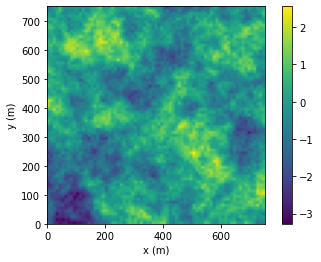

In [6]:
plt.figure()
plt.imshow(training_image, origin='lower', extent=extent_ti.ravel())
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

## Realizations

Normally the realizations would be generated from the training image using a multiple-point simulation method, but, for convenience again, we use Gaussian processes.

We define three different kernels representing three methods. One of those methods (labeled *TI* hereafter) uses the same kernel as the training image and, hopefully, ANODI should return that it's the closest method to the training image.

In [7]:
extent = np.array(((0, 500), (0, 500)))
shape = (50, 50)

In [8]:
grid = np.meshgrid(np.linspace(extent[0, 0], extent[0, 1], shape[0]),
                   np.linspace(extent[1, 0], extent[1, 1], shape[1]))
grid = np.stack(grid).T

In [9]:
n_realizations = 100
kernels = [kernel_ti,
           1.*Matern(length_scale=(150., 50.), nu=3/2),
           1.*Matern(length_scale=(10., 10.), nu=5/2)]
labels = ["TI", "Anisotropic", "Noisy"]

In [10]:
%%time

realizations = []
for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
    predictions = gp.sample_y(grid.reshape((-1, 2)), n_samples=n_realizations, random_state=42)
    predictions = predictions.T.reshape((n_realizations,) + shape)
    realizations.append(predictions)
realizations = np.stack(realizations)

CPU times: user 1min 57s, sys: 2.28 s, total: 2min
Wall time: 36.3 s


Let's have a look at a few realizations for each method (i.e., each kernel).

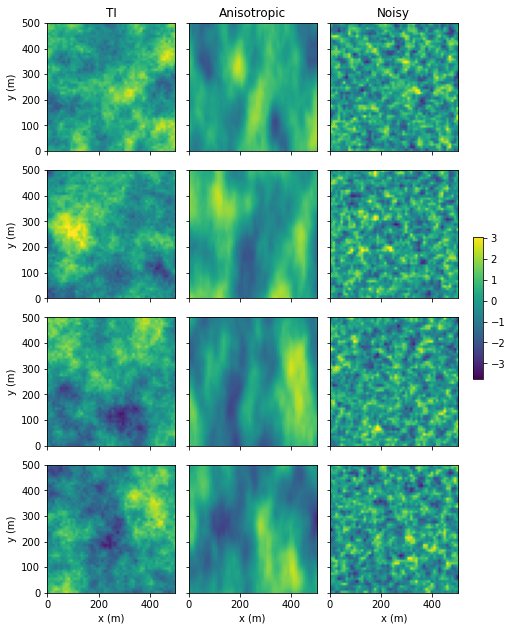

In [11]:
nrows = 4
fig, axs = plt.subplots(nrows=nrows,
                        ncols=realizations.shape[0],
                        sharex=True,
                        sharey=True,
                        figsize=(7, 8.65),
                        constrained_layout=True)
idx = np.random.randint(realizations.shape[1], size=nrows)
vmin = np.min(realizations[:, 0])
vmax = np.max(realizations[:, 0])
for (j, i), ax in np.ndenumerate(axs):
    if j == 0:
        ax.set_title(labels[i])
    image = ax.imshow(realizations[i, idx[j]],
                      vmin=vmin, vmax=vmax,
                      origin='lower', extent=extent.ravel())
    if j == nrows - 1:
        ax.set_xlabel("x (m)")
    if i == 0:
        ax.set_ylabel("y (m)")
fig.colorbar(image, ax=axs[:, -1], aspect=2.75, shrink=0.25)
plt.show()

# ANODI

Pyanodi's API is similar to scikit-learn's API: we create an *ANODI* object and call *fit_transform* to compute the prototype patterns and extract the histogram of patterns from the training image, extract the histogram of patterns form the realizations, and compute the distances between all those histograms. The same operations are performed over three pyramid levels to capture differences over several scales.

In [12]:
%%time

# Set the parameters
pyramid = (1, 2, 3)
anodi = ANODI(pyramid=pyramid,
              random_state=42,
              n_jobs=4)

# Perform the analysis
anodi.fit_transform(training_image, realizations)

Processing multiresolution grid 1
Template: 7*7
Processing training image
... Computing patterns
... ... Number of patterns: 4761
... Computing clusters
... ... Finding number of dimensions using PCA
... ... ... Initial dimensions: 49
... ... ... Reduced dimensions: 13
... ... Clustering patterns using kernel K-means
... Computing clusters' prototypes
Processing realizations
... method 3/3, realization 100/100    
Computing distances
... Within
... Between

Processing multiresolution grid 2
Template: 7*7
Processing training image
... Computing patterns
... ... Number of patterns: 961
... Computing clusters
... ... Finding number of dimensions using PCA
... ... ... Initial dimensions: 49
... ... ... Reduced dimensions: 13
... ... Clustering patterns using kernel K-means
... Computing clusters' prototypes
Processing realizations
... method 3/3, realization 100/100    
Computing distances
... Within
... Between

Processing multiresolution grid 3
Template: 7*7
Processing training image
...

We can now look at the scores comparing each method. Looking at the total score, the *TI* realizations are the closest to the training image, which is what we expected. The least similar realizations are the *Noisy* ones, which sounds acccurate since they barely have any spatial structure, contrary to the *Anisotropic* realizations, which as such are closer to the training image.

In [13]:
# Get the rankings of the methods
explanation = {'between': "Space of uncertainty (between) [higher = better]",
               'within': "Pattern reproduction (within) [lower = better]",
               'total': "Total (between/within) [higher = better]"}
ranking = anodi.score()
print("Ranking:    ", labels, "\n")
for key in ranking:
    print("    ", explanation[key])
    print("            ", ranking[key][:, 0], "\n")

Ranking:     ['TI', 'Anisotropic', 'Noisy'] 

     Space of uncertainty (between) [higher = better]
             [0.875      0.93022133 0.82103006] 

     Pattern reproduction (within) [lower = better]
             [0.875      0.99251882 0.99371456] 

     Total (between/within) [higher = better]
             [1.         0.93723294 0.82622323] 



We can visualize the distances using [scikit-learn's multidimensional scaling](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling), which represents each realization as a point in a nD space (here a 2D space for visualization purpose) and tries to have the distances between the points as close as possible to the input distances computed by ANODI.

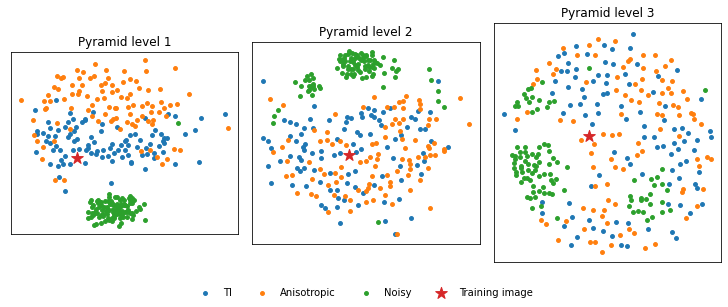

In [14]:
fig, axs = plt.subplots(ncols=len(pyramid),
                        figsize=(10, 4.5),
                        constrained_layout=True)
for i, ax in enumerate(axs):
    ax.set_title("Pyramid level " + str(i + 1))
    mds = MDS(n_components=2,
              dissimilarity='precomputed',
              random_state=42)
    mds_points = mds.fit_transform(anodi.distances_[..., i])
    for i in range(realizations.shape[0]):
        ax.scatter(mds_points[i*n_realizations:(i + 1)*n_realizations, 0],
                   mds_points[i*n_realizations:(i + 1)*n_realizations, 1],
                   s=15, label=labels[i])
    ax.scatter(mds_points[0, 0], mds_points[0, 1],
               s=150, marker='*', label="Training image")
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
handles_leg, labels_leg = ax.get_legend_handles_labels()
fig.legend(handles_leg, labels_leg, loc='lower center', ncol=4, frameon=False)
plt.show()

We can also have a look at the prototypes that were used to compute the histograms of patterns.

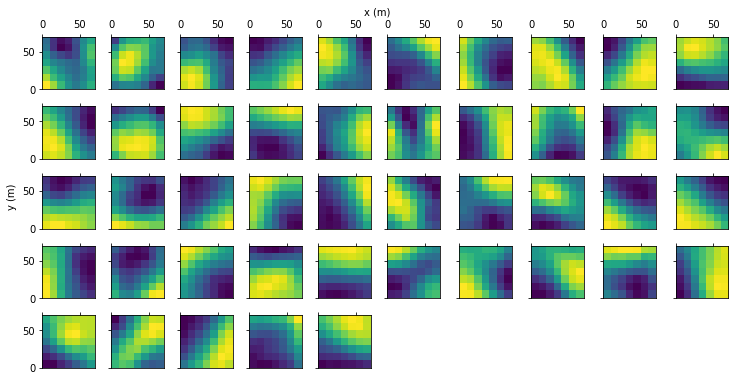

In [15]:
pyramid_level = 1
ncols = 10
nrows = int(np.ceil(anodi.prototypes_[pyramid_level].shape[0]/ncols))
width = 10
height = width*nrows/ncols
spacing = (extent[:, 1] - extent[:, 0])/shape
extent_prototypes = (0, anodi.prototypes_[pyramid_level].shape[2]*spacing[0],
                     0, anodi.prototypes_[pyramid_level].shape[1]*spacing[1])
fig, axs = plt.subplots(ncols=ncols,
                        nrows=nrows,
                        figsize=(width, height),
                        constrained_layout=True)
for j in range(nrows):
    for i in range(ncols):
        k = j*ncols + i
        if k < anodi.prototypes_[pyramid_level].shape[0]:
            axs[j, i].imshow(anodi.prototypes_[pyramid_level][k],
                             origin='lower', extent=extent_prototypes)
        else:
            axs[j, i].axis('off')
        axs[j, i].xaxis.tick_top()
        if j > 0:
            axs[j, i].set_xticklabels([])
        if i > 0:
            axs[j, i].set_yticklabels([])
fig.text(0.5, 1., "x (m)", ha='center', va='bottom')
fig.text(0., 0.5, "y (m)", ha='right', va='center', rotation='vertical')
plt.show()